In [ ]:
pip install yfinance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from math import sqrt
import seaborn as sns
sns.set()
import yfinance as yf
import datetime as dt

## Importing the Data and Pre-processing

In [2]:
raw_csv_data = pd.read_csv(".../Index2018.csv")
df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace = True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method = "ffill")

In [3]:
df_comp['market_value_ftse'] = df_comp.ftse

In [4]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## Creating Returns

In [5]:
df['returns'] = df.market_value_ftse.pct_change(1).mul(100)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_17296\1811906496.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['returns'] = df.market_value_ftse.pct_change(1).mul(100)


## LLR Test

In [6]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR =(2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

## Higher-Lag ARMA Models

In [7]:
# Fit the (3,2)ARMA model to FTSE returns
model_ret_arma_32 = ARIMA(df.returns[1:], order=(3, 0, 2))
results_ret_arma_32 = model_ret_arma_32.fit()

# Fit the (2,2)ARMA model to FTSE returns
model_ret_arma_22 = ARIMA(df.returns[1:], order=(2, 0, 2))
results_ret_arma_22 = model_ret_arma_22.fit()


# Fit the (1,3)ARMA model to FTSE returns
model_ret_arma_13 = ARIMA(df.returns[1:], order=(1, 0, 3))
results_ret_arma_13 = model_ret_arma_13.fit()

In [8]:
# Print the likelihood log and AIC for each model
print("Model (3,2)ARMA:")
print(results_ret_arma_32.summary())
print("Log Likelihood: ", results_ret_arma_32.llf)
print("AIC: ", results_ret_arma_32.aic)
print("\n")
print("Model (2,2)ARMA:")
print(results_ret_arma_22.summary())
print("Log Likelihood: ", results_ret_arma_22.llf)
print("AIC: ", results_ret_arma_22.aic)
print("\n")
print("Model (1,3)ARMA:")
print(results_ret_arma_13.summary())
print("Log Likelihood: ", results_ret_arma_13.llf)
print("AIC: ", results_ret_arma_13.aic)

Model (3,2)ARMA:
                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -7895.747
Date:                Mon, 26 Jun 2023   AIC                          15805.495
Time:                        19:57:47   BIC                          15851.143
Sample:                    01-10-1994   HQIC                         15821.491
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.211      0.226      -0.012       0.049
ar.L1         -0.6778      0.055    -12.298      0.000      -0.786      -0.570
ar.L2         -0.5082      0.063   

# The Best ARMA Model

In [9]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

best_aic = float("inf")
best_order = None
best_loglik = float("-inf")
best_order2 = None

# increase order of p and q from 1 to 5 separately and simultaneously
for p in range(1, 6):
    for q in range(1, 6):
        # fit ARMA model and save the output
        model = ARIMA(df.returns[1:], order=(p, 0, q))
        results = model.fit()
        output_file_name = f"model_ret_arma_p{p}q{q}.txt"
        with open(output_file_name, 'w') as f:
            f.write(str(results.summary()))

        # check if this model has the best AIC and the best log-likelihood so far
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = (p, 0, q)
        if results.llf > best_loglik:
            best_loglik = results.llf
            best_order2 = (p, 0, q)

# compare the best model to (3,3)ARMA
print(f"Best AIC: {best_aic}, Best Order: {best_order}")
print(f"(3,3)ARMA AIC: {ARIMA(df.returns[1:], order=(3, 0, 3)).fit().aic}") 
print(f"Best log-likelihood: {best_loglik}, Best Order: {best_order2}")
print(f"(3,3)ARMA log-likelihood: {ARIMA(df.returns[1:], order=(3, 0, 3)).fit().llf}")

C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\lenovo\anaconda3\

Best AIC: 15787.37541748292, Best Order: (2, 0, 5)
(3,3)ARMA AIC: 15803.030090152917
Best log-likelihood: -7882.72783196472, Best Order: (4, 0, 5)
(3,3)ARMA log-likelihood: -7893.515045076459


In [10]:
# Fit the (3,3)ARMA model to FTSE returns
model_ret_arma_33 = ARIMA(df.returns[1:], order=(3, 0, 3))
results_ret_arma_33 = model_ret_arma_33.fit()

# Fit the (2,5)ARMA model to FTSE returns
model_ret_arma_25 = ARIMA(df.returns[1:], order=(2, 0, 5))
results_ret_arma_25 = model_ret_arma_25.fit()

# Fit the (4,5)ARMA model to FTSE returns
model_ret_arma_45 = ARIMA(df.returns[1:], order=(4, 0, 5))
results_ret_arma_45 = model_ret_arma_45.fit()

C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [11]:
# Print the likelihood log and AIC for each model
print("Model (3,3)ARMA:")
print(results_ret_arma_33.summary())
print("Log Likelihood: ", results_ret_arma_33.llf)
print("AIC: ", results_ret_arma_33.aic)
print("\n")
print("Model (2,5)ARMA:")
print(results_ret_arma_25.summary())
print("Log Likelihood: ", results_ret_arma_25.llf)
print("AIC: ", results_ret_arma_25.aic)
print("\n")
print("Model (4,5)ARMA:")
print(results_ret_arma_45.summary())
print("Log Likelihood: ", results_ret_arma_45.llf)
print("AIC: ", results_ret_arma_45.aic)

Model (3,3)ARMA:
                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -7893.515
Date:                Mon, 26 Jun 2023   AIC                          15803.030
Time:                        20:00:12   BIC                          15855.200
Sample:                    01-10-1994   HQIC                         15821.311
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.281      0.200      -0.010       0.048
ar.L1         -0.1880      0.068     -2.780      0.005      -0.321      -0.055
ar.L2         -0.2926      0.054   

In [12]:
LLR_test(model_ret_arma_25, model_ret_arma_45, DF = 4)

C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.417

# Residuals for Returns

In [13]:
df['res_ret_arma_33'] = results_ret_arma_33.resid[1:]
print("The mean of the residuals is " + str(round(df.res_ret_arma_33.mean(),3)) + 
      "\nThe variance of the residuals is " + str(round(df.res_ret_arma_33.var(),3)))
round(sqrt(df.res_ret_arma_33.var()),3)
# in the worst case scenario we could be 1.164*3 = 3.5% up or down of the mean of Returns 

The mean of the residuals is 0.0
The variance of the residuals is 1.36


C:\Users\lenovo\AppData\Local\Temp\ipykernel_17296\3430939136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res_ret_arma_33'] = results_ret_arma_33.resid[1:]


1.166

In [14]:
df['res_ret_arma_25'] = results_ret_arma_25.resid[1:]
print("The mean of the residuals is " + str(round(df.res_ret_arma_25.mean(),3)) + 
      "\nThe variance of the residuals is " + str(round(df.res_ret_arma_25.var(),3)))
round(sqrt(df.res_ret_arma_25.var()),3)
# in the worst case scenario we could be 1.164*3 = 3.5% up or down of the mean of Returns 

The mean of the residuals is -0.0
The variance of the residuals is 1.355


C:\Users\lenovo\AppData\Local\Temp\ipykernel_17296\1815794992.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res_ret_arma_25'] = results_ret_arma_25.resid[1:]


1.164

In [15]:
df['res_ret_arma_45'] = results_ret_arma_45.resid[1:]
print("The mean of the residuals is " + str(round(df.res_ret_arma_45.mean(),3)) + 
      "\nThe variance of the residuals is " + str(round(df.res_ret_arma_45.var(),3)))
round(sqrt(df.res_ret_arma_45.var()),3)
# in the worst case scenario we could be 1.164*3 = 3.5% up or down of the mean of Returns 

The mean of the residuals is -0.0
The variance of the residuals is 1.354


C:\Users\lenovo\AppData\Local\Temp\ipykernel_17296\2969185924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res_ret_arma_45'] = results_ret_arma_45.resid[1:]


1.164

# ACF of Residuals for ARMA Model

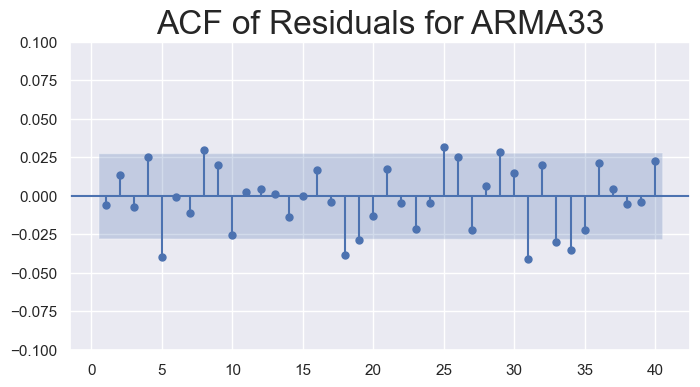

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))
sgt.plot_acf(df.res_ret_arma_33[2:], zero=False, lags=40, ax=ax)
ax.set_ylim(-0.1, 0.1)
plt.title("ACF of Residuals for ARMA33", size=24)
plt.show()

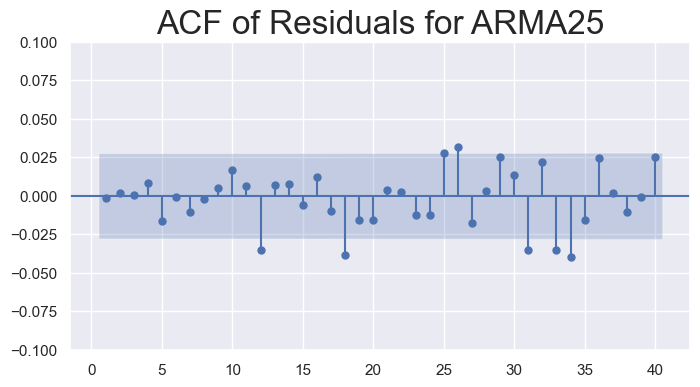

In [17]:
fig, ax = plt.subplots(figsize=(8, 4))
sgt.plot_acf(df.res_ret_arma_25[2:], zero=False, lags=40, ax=ax)
ax.set_ylim(-0.1, 0.1)
plt.title("ACF of Residuals for ARMA25", size=24)
plt.show()

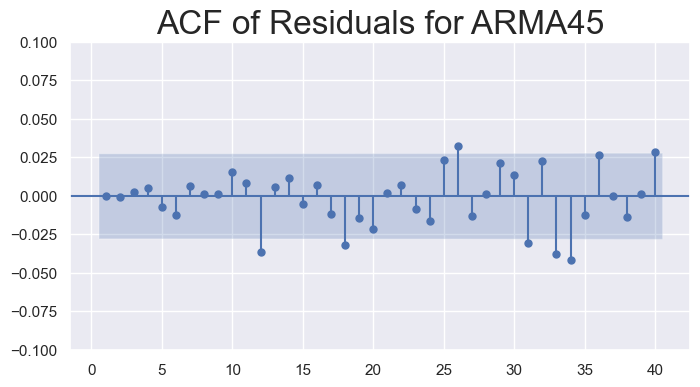

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))
sgt.plot_acf(df.res_ret_arma_45[2:], zero=False, lags=40, ax=ax)
ax.set_ylim(-0.1, 0.1)
plt.title("ACF of Residuals for ARMA45", size=24)
plt.show()

# Importing the Data from yfinance

In [30]:
tickers = ["MSFT"]

# specify the start and end dates for the data
start_date = dt.datetime(2010, 1, 1)
end_date = dt.datetime(2022, 6, 30)

data = yf.download(tickers, start=start_date, end=end_date)
df_data = data.copy()
df_data.index = pd.to_datetime(df_data.index)

size = int(len(df_data)*0.8)
df, df_test = df_data.iloc[:size], df_data.iloc[size:]

print(df_data.head())

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2010-01-04  30.620001  31.100000  30.590000  30.950001  23.572369  38409100
2010-01-05  30.850000  31.100000  30.639999  30.959999  23.579987  49749600
2010-01-06  30.879999  31.080000  30.520000  30.770000  23.435282  58182400
2010-01-07  30.629999  30.700001  30.190001  30.450001  23.191559  50559700
2010-01-08  30.280001  30.879999  30.240000  30.660000  23.351494  51197400


# The DF-Test

In [31]:
sts.adfuller(df_data.Close)

(0.9786115448908139,
 0.9940350699937751,
 26,
 3117,
 {'1%': -3.4324496770876256,
  '5%': -2.8624677069228635,
  '10%': -2.567263840611819},
 13786.948282578192)

# Return of MSFT

In [32]:
df['returns_MSFT'] = df.Close.pct_change(1).mul(100)
df = df.iloc[1:]

C:\Users\lenovo\AppData\Local\Temp\ipykernel_17296\3369984590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['returns_MSFT'] = df.Close.pct_change(1).mul(100)


In [33]:
sts.adfuller(df.returns_MSFT)

(-20.322747574236995,
 0.0,
 7,
 2506,
 {'1%': -3.432962135264372,
  '5%': -2.862694028699462,
  '10%': -2.567384333962417},
 8833.332932267824)

# ACF and PACF for Returns of MSFT

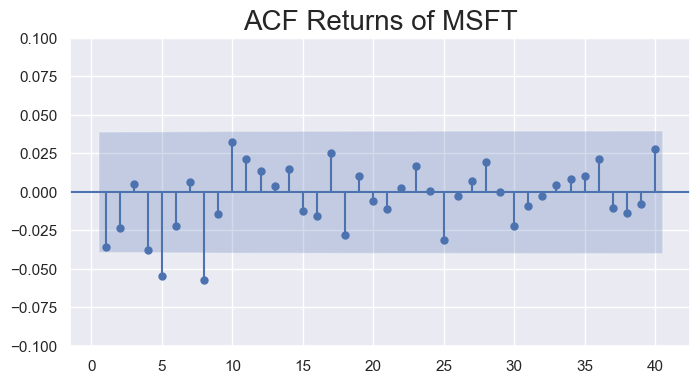

In [34]:
fig, ax = plt.subplots(figsize=(8, 4))
sgt.plot_acf(df.returns_MSFT, lags = 40, zero = False, ax = ax)
ax.set_ylim(-0.1, 0.1)
plt.title("ACF Returns of MSFT", size = 20)
plt.show()

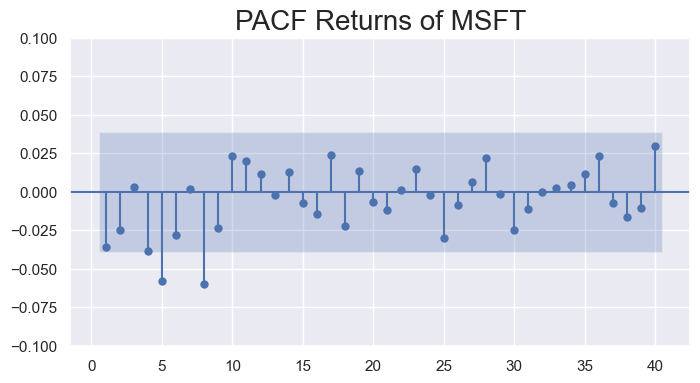

In [35]:
fig, ax = plt.subplots(figsize=(8, 4))
sgt.plot_pacf(df.returns_MSFT[1:], lags = 40, zero = False, method = ('ols') , ax = ax)
ax.set_ylim(-0.1, 0.1)
plt.title("PACF Returns of MSFT", size = 20)
plt.show()

# The optimal ARMA model

In [36]:
model_ret_arma_55 = ARIMA(df.returns_MSFT[1:], order = (5,0,5))
results_ret_arma_55 = model_ret_arma_55.fit()
results_ret_arma_55.summary()

C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           returns_MSFT   No. Observations:                 2513
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -4457.173
Date:                Mon, 26 Jun 2023   AIC                           8938.345
Time:                        20:26:37   BIC                           9008.296
Sample:                             0   HQIC                          8963.734
                               - 2513                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0752      0.025      3.048      0.002       0.027       0.124
ar.L1          0.2875      0.235      1.221      0.222      -0.174       0.749
ar.L2          0.2455      0.200      1.231      0.218      -0.145       0.637
ar.L3          0.0095      0.174      0.055      0.956      -0.332       0.351
ar.L4          0.3548      0.172      2.057      0.040       0.017       0.693
ar.L5         -0.5649      0.143     -3.952      0.000      -0.845      -0.285
ma.L1         -0.3275      0.239     -1.370      0.171      -0.796       0.141
ma.L2         -0.2623      0.205     -1.277      0.202      -0.665       0.140
ma.L3          0.0166      0.177      0.094      0.925      -0.331       0.364
ma.L4         -0.3971      0.176     -2.253      0.024      -0.743      -0.052
ma.L5          0.5311      0.155      3.436      0.001       0.228       0.834
sigma2         2.0371      0.030     68.109      0.000       1.978       2.096
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4162.04
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.01
Prob(H) (two-sided):                  0.17   Kurtosis:                         9.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
model_ret_arma_88 = ARIMA(df.returns_MSFT[1:], order = (8,0,8))
results_ret_arma_88 = model_ret_arma_88.fit()
results_ret_arma_88.summary()

C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           returns_MSFT   No. Observations:                 2513
Model:                 ARIMA(8, 0, 8)   Log Likelihood               -4452.392
Date:                Mon, 26 Jun 2023   AIC                           8940.785
Time:                        20:27:13   BIC                           9045.711
Sample:                             0   HQIC                          8978.868
                               - 2513                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0753      0.024      3.088      0.002       0.027       0.123
ar.L1          0.4657      0.144      3.231      0.001       0.183       0.748
ar.L2         -0.2736      0.128     -2.138      0.033      -0.524      -0.023
ar.L3         -0.0302      0.131     -0.231      0.817      -0.286       0.226
ar.L4         -0.1195      0.120     -0.993      0.321      -0.355       0.116
ar.L5          0.2696      0.102      2.650      0.008       0.070       0.469
ar.L6         -0.2766      0.120     -2.312      0.021      -0.511      -0.042
ar.L7          0.4892      0.121      4.032      0.000       0.251       0.727
ar.L8         -0.6357      0.111     -5.712      0.000      -0.854      -0.418
ma.L1         -0.5098      0.149     -3.431      0.001      -0.801      -0.219
ma.L2          0.2620      0.135      1.945      0.052      -0.002       0.526
ma.L3          0.0299      0.138      0.217      0.828      -0.240       0.300
ma.L4          0.0711      0.124      0.575      0.565      -0.171       0.314
ma.L5         -0.3002      0.109     -2.755      0.006      -0.514      -0.087
ma.L6          0.2776      0.127      2.189      0.029       0.029       0.526
ma.L7         -0.5032      0.130     -3.881      0.000      -0.757      -0.249
ma.L8          0.5888      0.123      4.779      0.000       0.347       0.830
sigma2         2.0273      0.030     66.642      0.000       1.968       2.087
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              4139.16
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.01
Prob(H) (two-sided):                  0.16   Kurtosis:                         9.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
LLR_test(model_ret_arma_55, model_ret_arma_88)

C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.002

In [39]:
from statsmodels.tsa.arima.model import ARIMA

best_aic = float("inf")
best_order = None

# increase order of p and q from 1 to 10 separately and simultaneously
for p in range(1, 10):
    for q in range(1, 10):
        # fit ARMA model and save the output
        model = ARIMA(df.returns_MSFT[1:], order=(p, 0, q))
        results = model.fit()
        output_file_name = f"model_ret_arma_p{p}q{q}.txt"
        with open(output_file_name, 'w') as f:
            f.write(str(results.summary()))

        # check if this model has the best AIC and the best log-likelihood so far
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = (p, 0, q)

print(f"Best AIC: {best_aic}, Best Order: {best_order}")

C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dat

Best AIC: 8935.119822084042, Best Order: (8, 0, 2)


In [41]:
model_ret_arma_82 = ARIMA(df.returns_MSFT[1:], order = (8,0,2))
results_ret_arma_82 = model_ret_arma_82.fit()
results_ret_arma_82.summary()

C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           returns_MSFT   No. Observations:                 2513
Model:                 ARIMA(8, 0, 2)   Log Likelihood               -4455.560
Date:                Mon, 26 Jun 2023   AIC                           8935.120
Time:                        20:35:52   BIC                           9005.071
Sample:                             0   HQIC                          8960.509
                               - 2513                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0752      0.023      3.250      0.001       0.030       0.121
ar.L1          0.3492      0.241      1.452      0.147      -0.122       0.821
ar.L2         -0.3906      0.239     -1.635      0.102      -0.859       0.078
ar.L3         -0.0081      0.022     -0.374      0.708      -0.051       0.034
ar.L4         -0.0538      0.021     -2.613      0.009      -0.094      -0.013
ar.L5         -0.0425      0.023     -1.848      0.065      -0.088       0.003
ar.L6         -0.0224      0.024     -0.945      0.345      -0.069       0.024
ar.L7         -0.0125      0.023     -0.540      0.589      -0.058       0.033
ar.L8         -0.0730      0.019     -3.800      0.000      -0.111      -0.035
ma.L1         -0.3910      0.242     -1.619      0.105      -0.864       0.082
ma.L2          0.3798      0.244      1.557      0.120      -0.098       0.858
sigma2         2.0302      0.029     70.389      0.000       1.974       2.087
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4182.52
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                             0.01
Prob(H) (two-sided):                  0.14   Kurtosis:                         9.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Residuals for Returns_MSFT

In [46]:
df['res_ret_arma_55'] = results_ret_arma_55.resid[1:]
print("The mean of the residuals is " + str(round(df.res_ret_arma_55.mean(),3)) + 
      "\nThe variance of the residuals is " + str(round(df.res_ret_arma_55.var(),3)))
round(sqrt(df.res_ret_arma_55.var()),3)
# in the worst case scenario we could be 1.164*3 = 3.5% up or down of the mean of Returns 

The mean of the residuals is 0.0
The variance of the residuals is 2.034


1.426

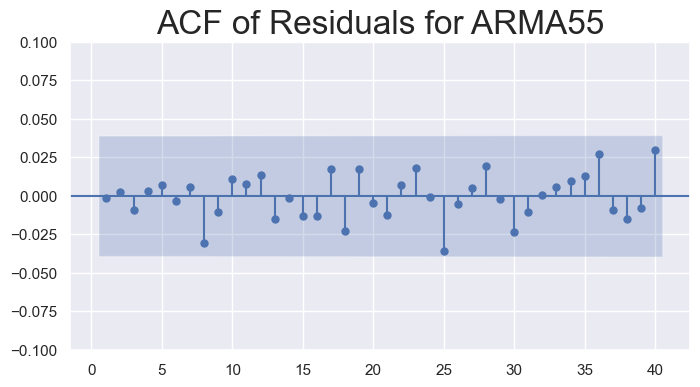

In [47]:
fig, ax = plt.subplots(figsize=(8, 4))
sgt.plot_acf(df.res_ret_arma_55[2:], zero=False, lags=40, ax=ax)
ax.set_ylim(-0.1, 0.1)
plt.title("ACF of Residuals for ARMA55", size=24)
plt.show()

In [48]:
df['res_ret_arma_82'] = results_ret_arma_82.resid[1:]
print("The mean of the residuals is " + str(round(df.res_ret_arma_82.mean(),3)) + 
      "\nThe variance of the residuals is " + str(round(df.res_ret_arma_82.var(),3)))
round(sqrt(df.res_ret_arma_82.var()),3)
# in the worst case scenario we could be 1.164*3 = 3.5% up or down of the mean of Returns 

The mean of the residuals is 0.0
The variance of the residuals is 2.032


1.425

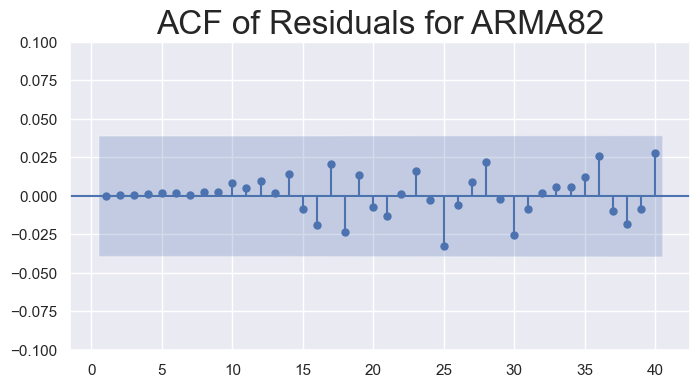

In [49]:
fig, ax = plt.subplots(figsize=(8, 4))
sgt.plot_acf(df.res_ret_arma_82[2:], zero=False, lags=40, ax=ax)
ax.set_ylim(-0.1, 0.1)
plt.title("ACF of Residuals for ARMA82", size=24)
plt.show()